In [2]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask, reshape
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
mr_data_path='input_data/deg/0_5x0_5/'
hr_data_path='input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484

In [4]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                    'all', 2000, 2020, global_mean, global_Std)

In [5]:
edsr_model_step1 = tf.keras.models.load_model('models/edsr_model_1to0_5_deg_all.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)
edsr_model_step2 = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_all.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [ ]:
medium_res_output = edsr_model_step1.predict(testX)
# pred_high_res = edsr_model_step2.predict(medium_res_output)
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model_step2.evaluate(medium_res_output, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0043 - mae: 0.0043 - mse: 6.5445e-05 - psnr: 41.8448 - ssim: 0.9720
Test Loss: 0.004307134076952934
Test PSNR: 41.842472076416016
Test SSIM: 0.9720607399940491
Test MSE: 6.548107921844348e-05
Test MAE: 0.004307134076952934


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity

def overall_evaluate_per_pixel(model_1, model_2, low_res_data, high_res_data, regional=False, max_pixel=1.0):
    medium_res_output = model_1.predict(low_res_data)
    pred_high_res = model_2.predict(medium_res_output)

    if regional:
        pred_high_res = pred_high_res[:, 140:180, 310:350, :]
        high_res_data = high_res_data[:, 140:180, 310:350, :]

    # Compute per-pixel MSE and MAE
    per_pixel_mse = np.mean((pred_high_res - high_res_data) ** 2, axis=0)  # (H, W, C)
    per_pixel_mae = np.mean(np.abs(pred_high_res - high_res_data), axis=0)  # (H, W, C)

    # TensorFlow-based PSNR calculation per pixel
    per_pixel_psnr = np.zeros_like(per_pixel_mse)
    for i in range(per_pixel_mse.shape[0]):  # Loop over height
        for j in range(per_pixel_mse.shape[1]):  # Loop over width
            mse_pixel = per_pixel_mse[i, j]
            if mse_pixel > 0:
                per_pixel_psnr[i, j] = 10.0 * tf.math.log(max_pixel ** 2 / mse_pixel) / tf.math.log(10.0)
            else:
                per_pixel_psnr[i, j] = np.inf  # Perfect match

    # Compute SSIM per pixel (on grayscale channel)
    per_pixel_ssim = np.zeros_like(per_pixel_mse)
    for i in range(per_pixel_mse.shape[0]):  # Loop over height
        for j in range(per_pixel_mse.shape[1]):  # Loop over width
            try:
                per_pixel_ssim[i, j] = structural_similarity(
                    pred_high_res[:, i, j, 0], high_res_data[:, i, j, 0], data_range=max_pixel
                )
            except:
                per_pixel_ssim[i, j] = 0  # Handle edge cases

    return per_pixel_mse, per_pixel_mae, per_pixel_psnr, per_pixel_ssim

In [18]:
test_mse, test_mae, test_psnr, test_ssim = overall_evaluate_per_pixel(edsr_model_step1, edsr_model_step2, testX, testY)

print(test_mse.shape)
print(test_mae.shape)
print(test_psnr.shape)
print(test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
(320, 580, 1)
(320, 580, 1)
(320, 580, 1)
(320, 580, 1)
Mean Per-Pixel MSE: 6.548109e-05
Mean Per-Pixel MAE: 0.0043071336
Mean Per-Pixel PSNR: 47.772705
Mean Per-Pixel SSIM: 0.992537


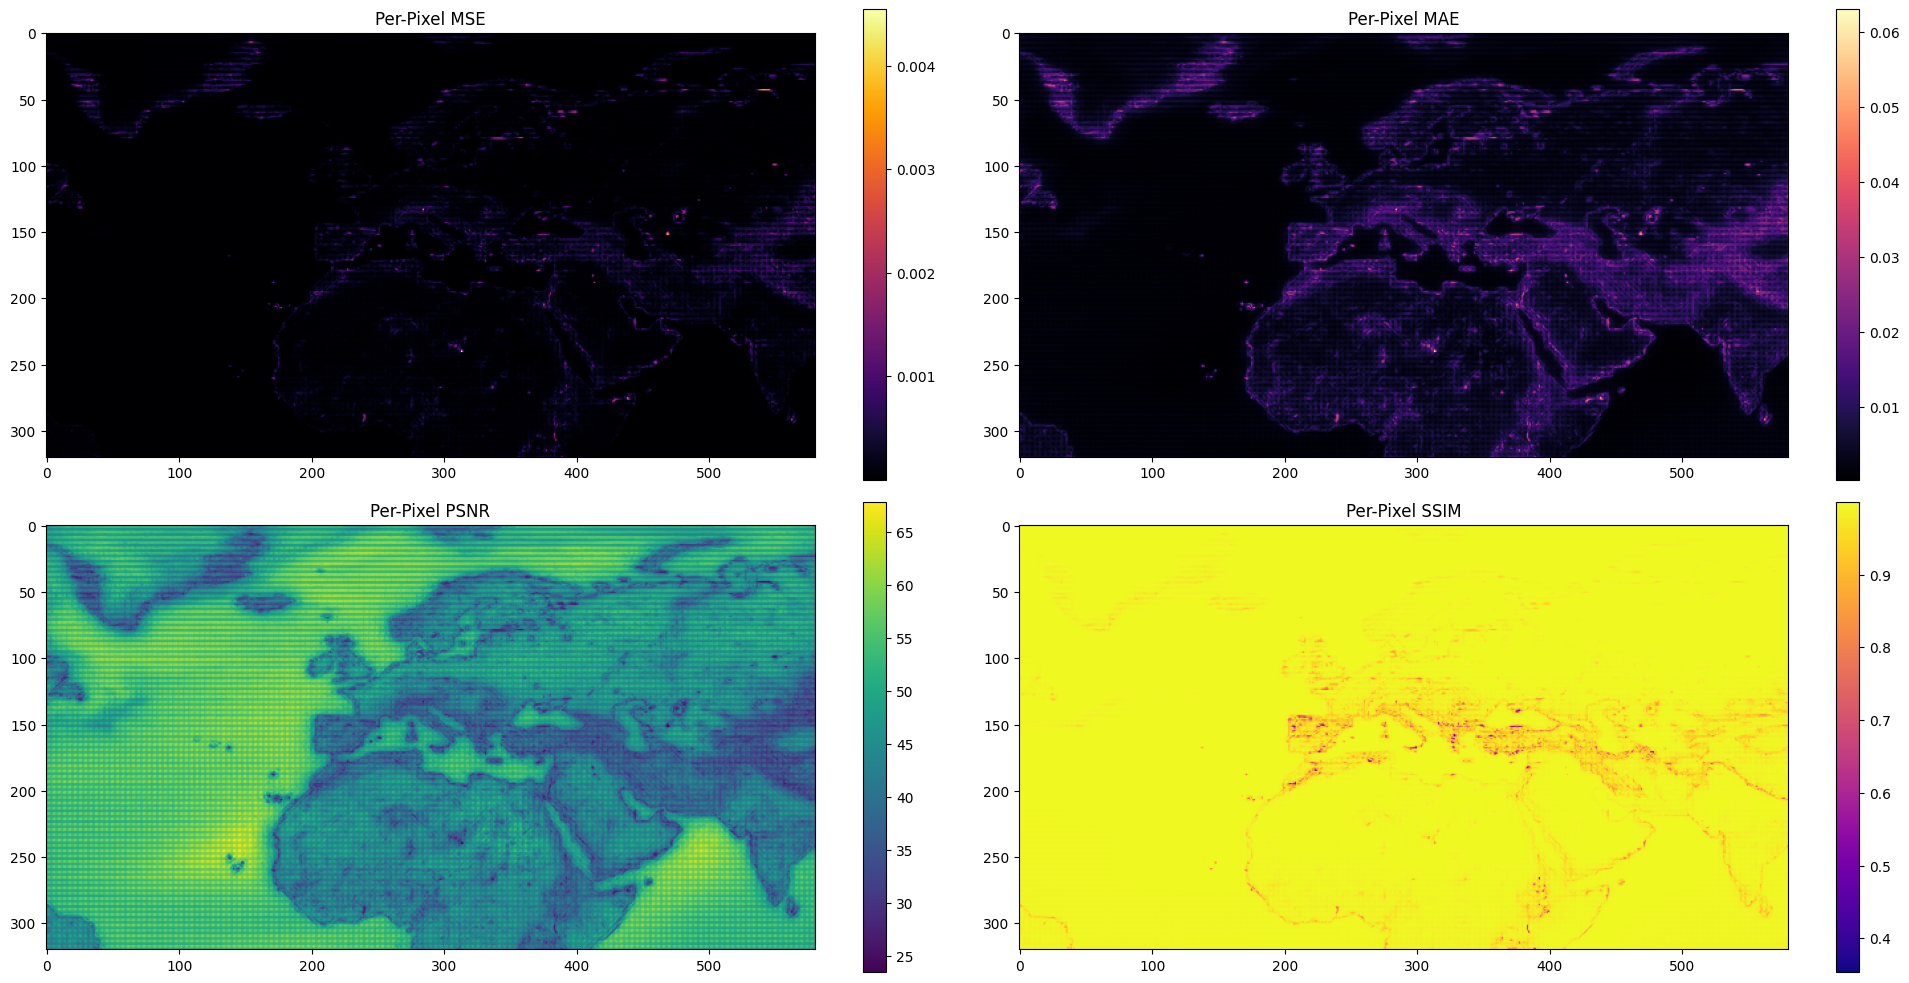

In [19]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.27676263
Max Degrees MAE: 4.044302
Min Degrees MAE: 0.017998211


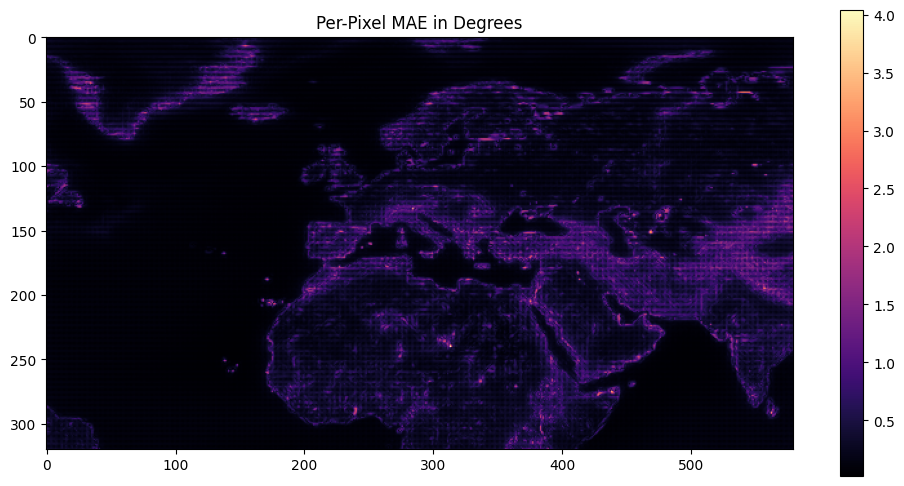

In [20]:
degrees_mae_2steps = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae_2steps))
print("Max Degrees MAE:", degrees_mae_2steps.max())
print("Min Degrees MAE:", degrees_mae_2steps.min())
plot_degrees_mae(degrees_mae_2steps)

In [ ]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.41915902
Mean Land-Pixels MAE: 0.0065231845


In [ ]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_25'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_25'))

Mean Coastline-Pixels Degrees MAE: 0.6341426
Mean Costline-Pixels MAE: 0.009868878


# **1 Step vs 2 Steps Downscaling**

In [6]:
medium_res_output = edsr_model_step1.predict(np.expand_dims(testX[1], axis=0))
high_res_output_2steps = edsr_model_step2.predict(medium_res_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


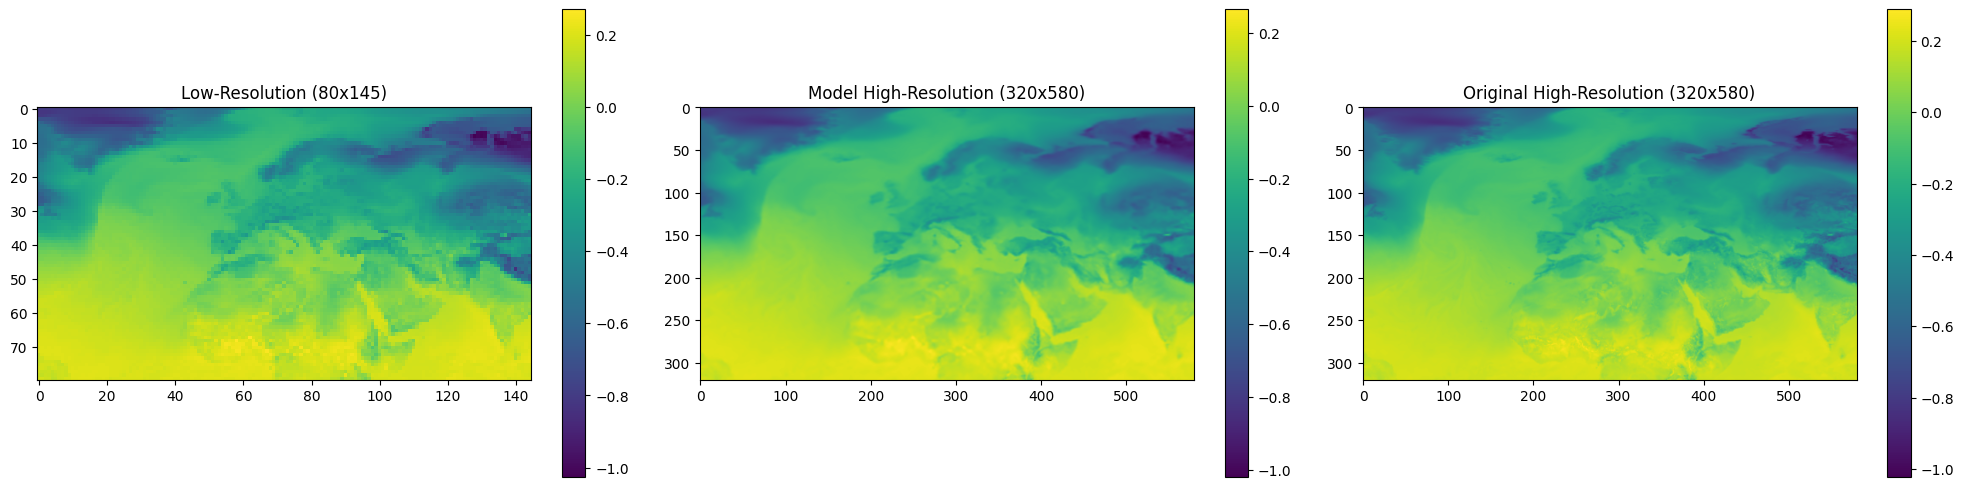

In [7]:
plot_to_compare(testX[1], testY[1],  np.squeeze(high_res_output_2steps), 'viridis')

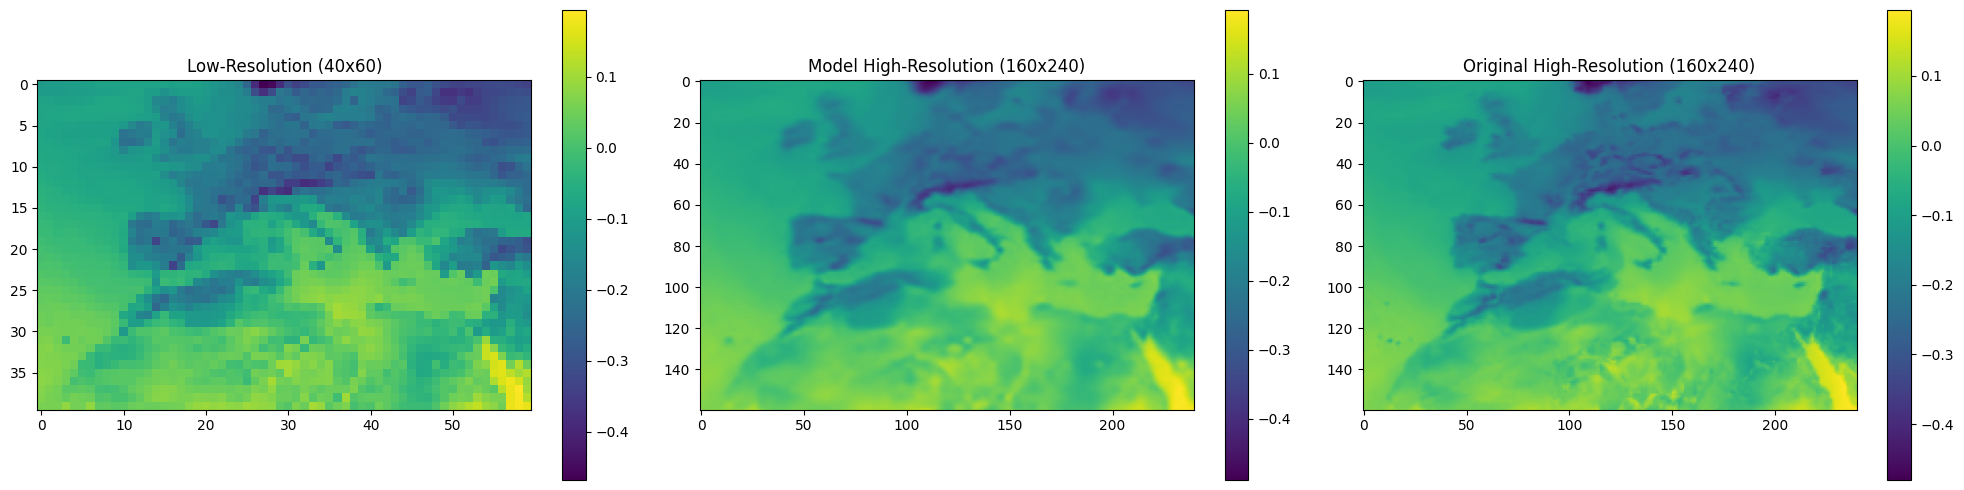

In [8]:
plot_to_compare(testX[1][20:60, 40:100], testY[1][80:240, 160:400],  np.squeeze(high_res_output_2steps)[80:240, 160:400], 'viridis')

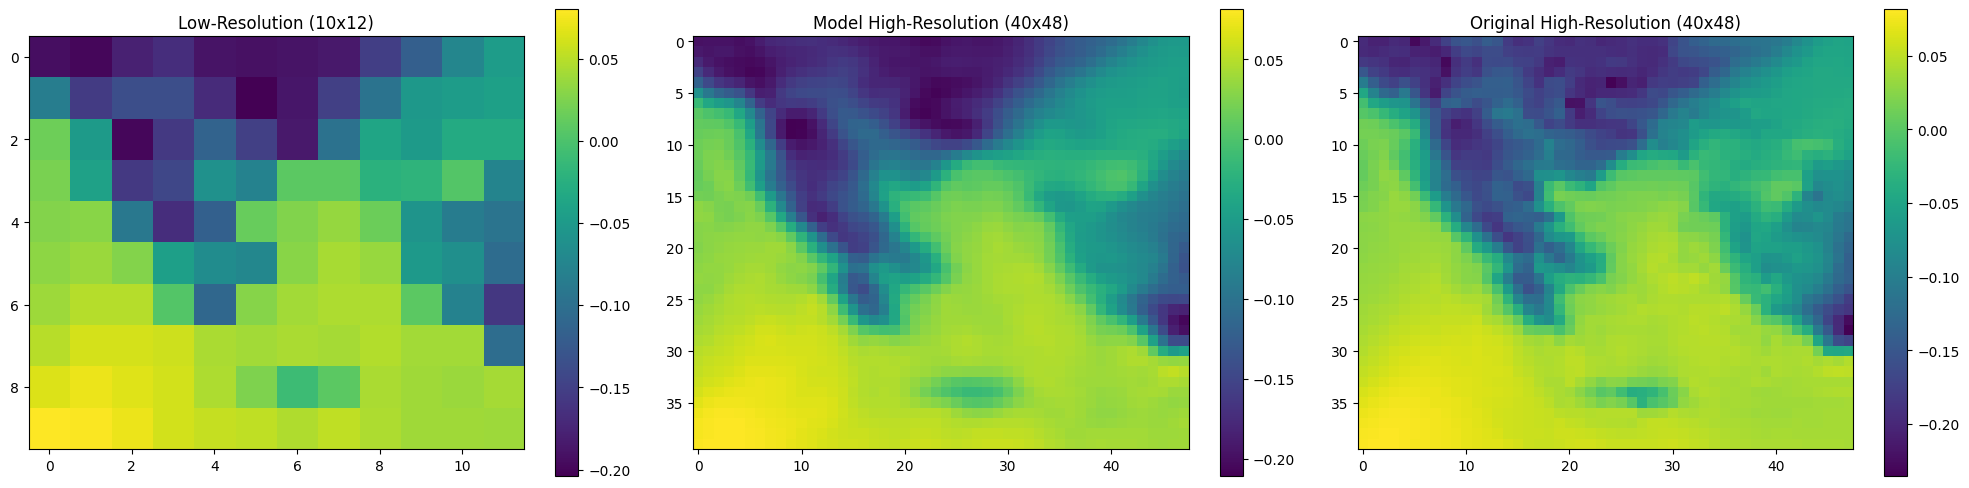

In [9]:
plot_to_compare(testX[1][36:46, 78:90], testY[1][144:184, 312:360],  np.squeeze(high_res_output_2steps)[144:184, 312:360], 'viridis')

In [10]:
edsr_model_1step = tf.keras.models.load_model('models/edsr_model_1to0_25_deg_all.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [12]:
high_res_output_1step = edsr_model_1step.predict(np.expand_dims(testX[1], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


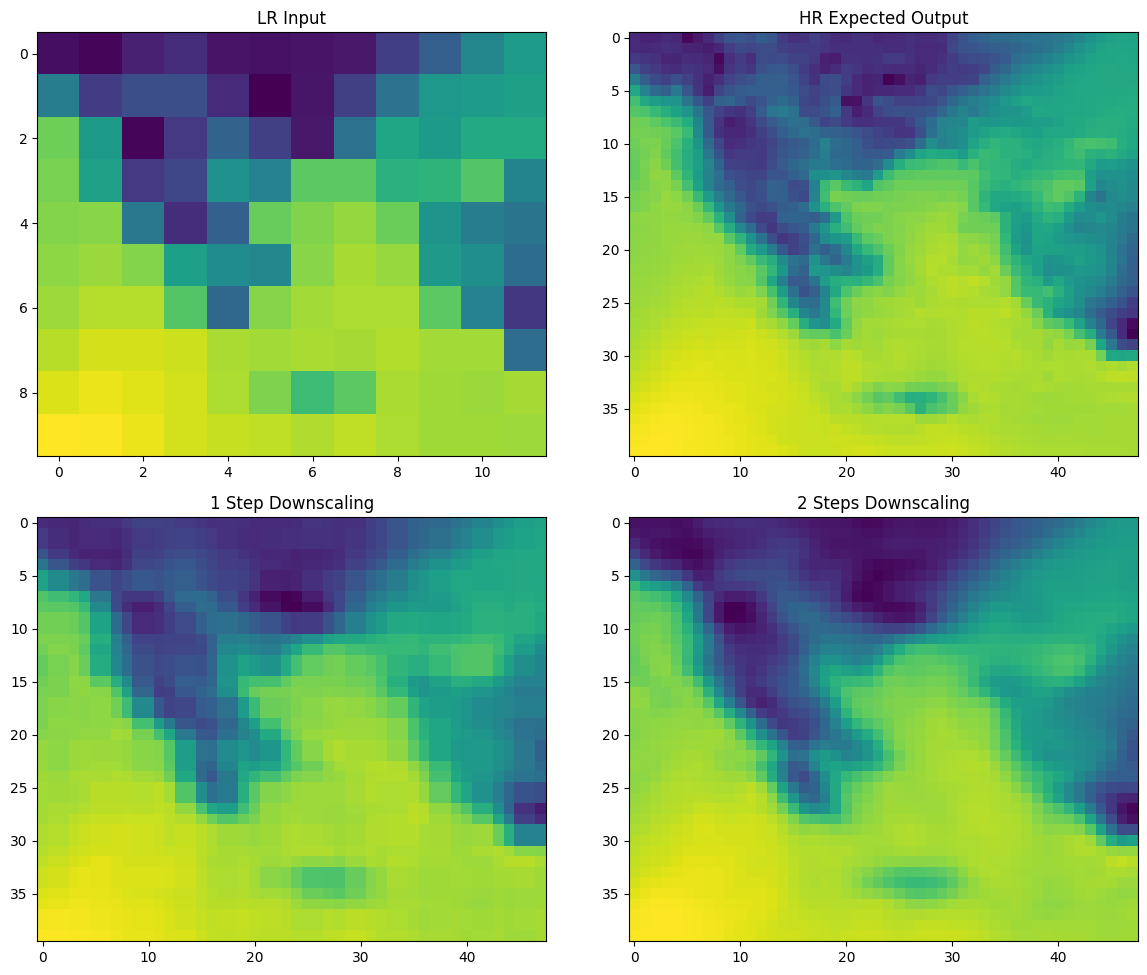

In [16]:
import matplotlib.pyplot as plt

# Plot the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('', fontsize=20)


im1 = axes[0, 0].imshow(testX[1][36:46, 78:90], cmap='viridis')
axes[0, 0].set_title("LR Input")

im2 = axes[0, 1].imshow(testY[1][144:184, 312:360], cmap='viridis')
axes[0, 1].set_title("HR Expected Output")

im3 = axes[1, 0].imshow(np.squeeze(high_res_output_1step)[144:184, 312:360], cmap='viridis')
axes[1, 0].set_title("1 Step Downscaling")

im4 = axes[1, 1].imshow(np.squeeze(high_res_output_2steps)[144:184, 312:360], cmap='viridis')
axes[1, 1].set_title("2 Steps Downscaling")

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model_1step, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 9.680909e-05
Mean Per-Pixel MAE: 0.0053308858
Mean Per-Pixel PSNR: 46.02265
Mean Per-Pixel SSIM: 0.9883061


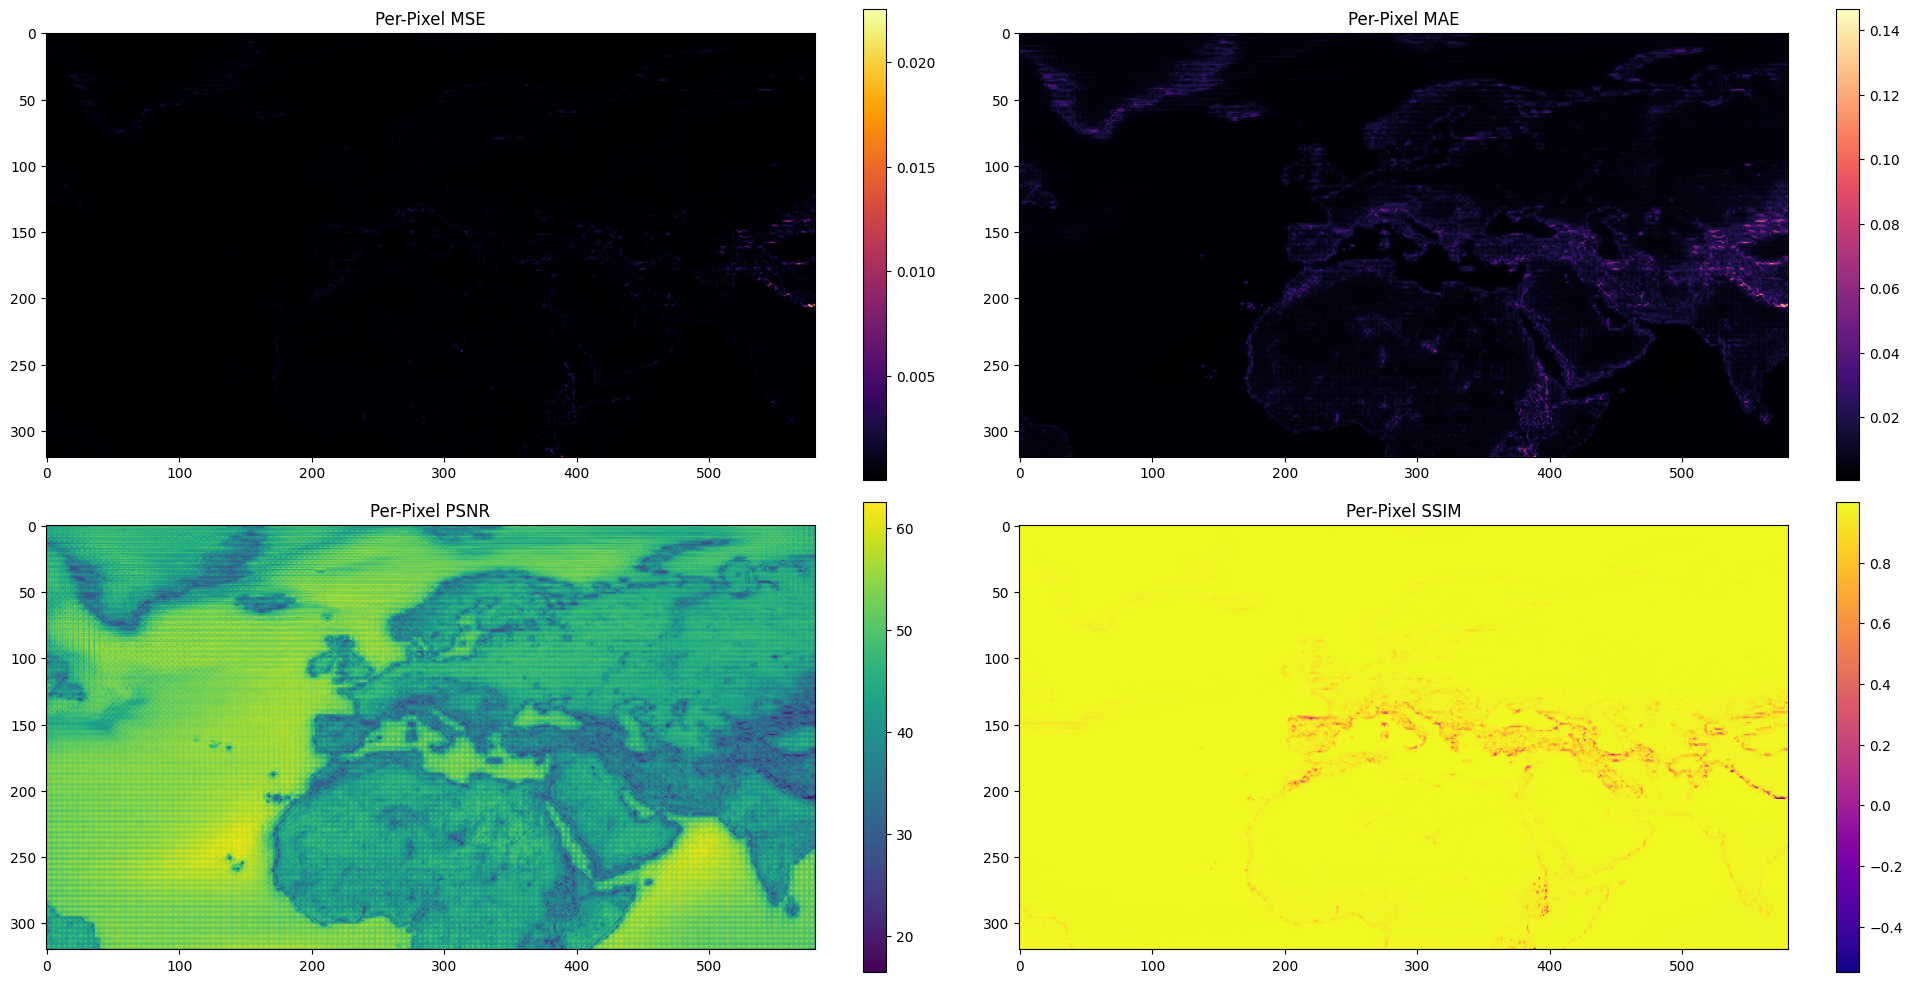

In [22]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.3425457
Max Degrees MAE: 9.40535
Min Degrees MAE: 0.034955826


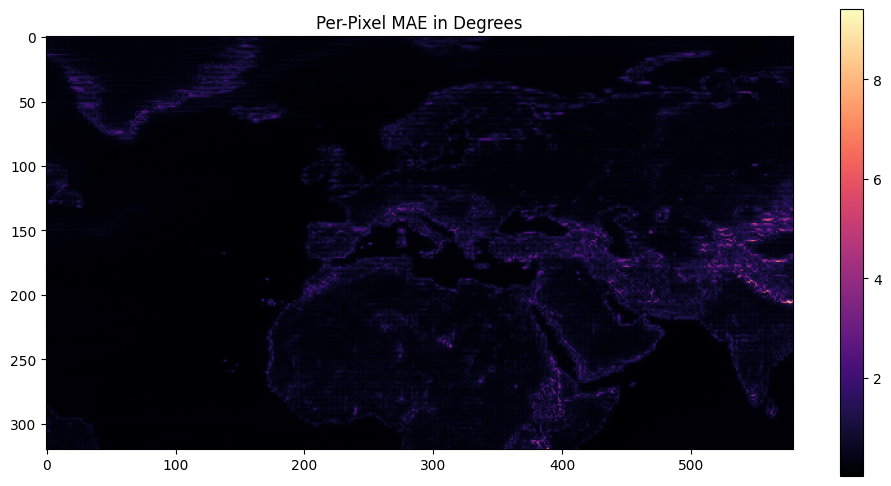

In [23]:
degrees_mae_1step = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae_1step))
print("Max Degrees MAE:", degrees_mae_1step.max())
print("Min Degrees MAE:", degrees_mae_1step.min())
plot_degrees_mae(degrees_mae_1step)

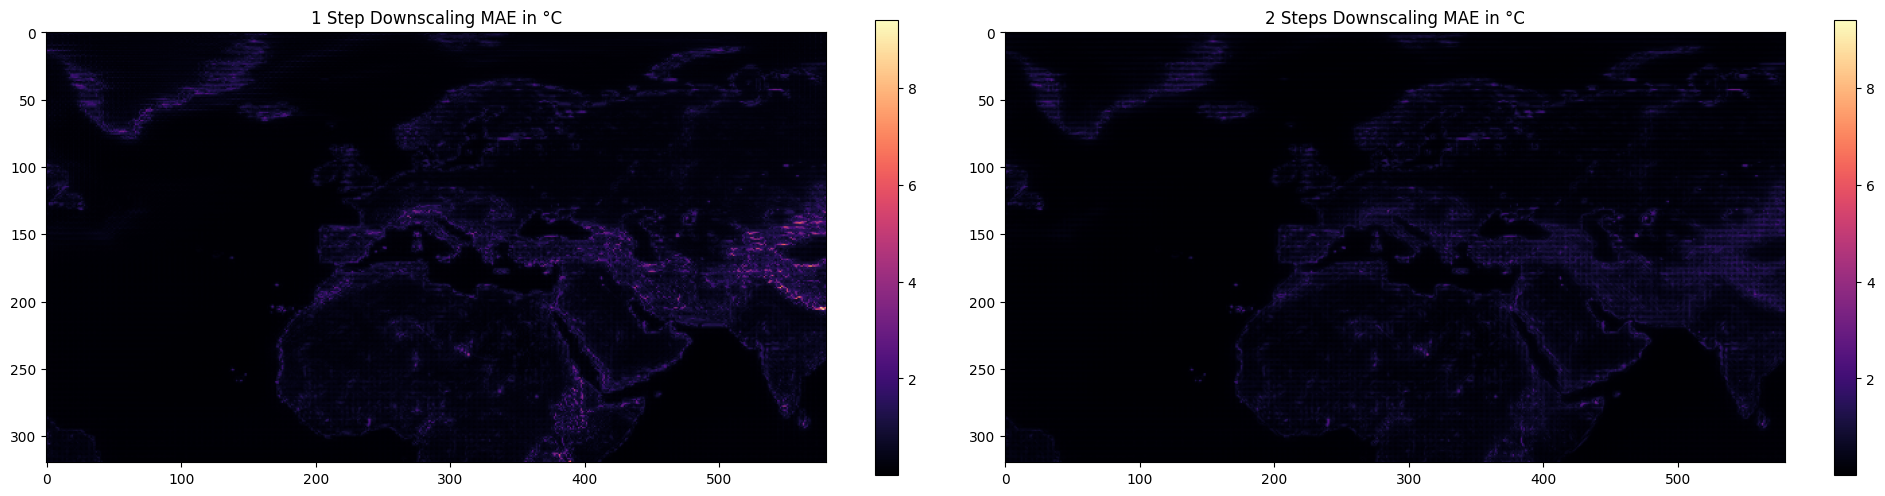

In [37]:
import matplotlib.pyplot as plt

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('', fontsize=20)

vmin = min(degrees_mae_1step.min(), degrees_mae_2steps.min())
vmax = max(degrees_mae_1step.max(), degrees_mae_2steps.max())

im1 = axes[0].imshow(degrees_mae_1step, cmap='magma', vmin=vmin, vmax=vmax)
axes[0].set_title("1 Step Downscaling MAE in °C")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(degrees_mae_2steps, cmap='magma', vmin=vmin, vmax=vmax)
axes[1].set_title("2 Steps Downscaling MAE in °C")
plt.colorbar(im2, ax=axes[1])

# Adjust layout
plt.tight_layout()
plt.show()